In [118]:
import numpy as np
import pandas as pd
from solve_additive import *
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('input_lab2.csv')

In [3]:
data.shape

(45, 11)

In [4]:
n1, n2, n3, m = 2, 2, 3, 4
P1, P2, P3 = 13, 11, 7

params = {
    'dimensions': [n1, n2, n3, m],
    'input_file': data,
    'output_file': 'test.xlsx',
    'degrees': [P1, P2, P3],
    'weights': 'Нормоване значення',
    'poly_type': 'Чебишова',
    'lambda_multiblock': False
}

solver = Solve(params)
func_runtimes = solver.prepare()

In [171]:
class Predictor:
    def __init__(self, solver):
        self.solver = solver
        psi = list()
        for i in range(self.solver.Y.shape[1]):  # `i` is an index for Y
            psi_i = list()
            shift = 0
            for j in range(3):  # `j` is an index to choose vector from X
                psi_i_j = list()
                for k in range(self.solver.dim[j]):  # `k` is an index for vector component
                    psi_i_j_k = self.solver.Lamb[shift:shift + self.solver.deg[j], i].ravel()
                    shift += self.solver.deg[j]
                    psi_i_j.append(psi_i_j_k)
                psi_i.append(psi_i_j)
            psi.append(psi_i)

        self.psi = psi
        self.a = solver.a.T.tolist()
        self.c = solver.c.T.tolist()
        self.X_min = self.solver.datas[:, :-self.solver.Y.shape[1]].min(axis=0)
        self.X_max = self.solver.datas[:, :-self.solver.Y.shape[1]].max(axis=0)
        self.Y_min, self.Y_max = solver.Y_.min(axis=0), solver.Y_.max(axis=0)

    def predict(self, X):
        Y = np.zeros((len(X), solver.Y.shape[1]))
        X_norm = (X - self.X_min) / (self.X_max - self.X_min)

        def evalF(x, i):
            res = 0
            for j in range(3):
                for k in range(len(self.psi[i][j])):
                    shift = sum(self.solver.dim[:j]) + k
                    for n in range(len(self.psi[i][j][k])):
                        coef = self.c[i][j] * self.a[i][shift] * self.psi[i][j][k][n]
                        res += coef * solver.poly_f(n, x[:, shift])
            return res

        res = np.array([evalF(X_norm, i) for i in range(Y.shape[1])]).T
        return res * (self.Y_max - self.Y_min) + self.Y_min
    

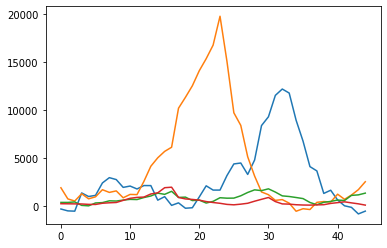

In [173]:
pred = Predictor(solver)
plt.plot(pred.predict(data[:, :n1+n2+n3]))